In [1]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from tqdm import tqdm
from math import sqrt
import numpy as np
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import shap

## Set global parameters

In [2]:
# 设置全局控制的变量
freq = 'D'
region = 'NA'
model_sty = 'transformer'

if freq == 'H':
    data_num = 17520
    list_col = ['NO2+h','NO2-h','NO2-2h','NO2-3h']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'
if freq == '3H':
    data_num = 5840
    list_col = ['NO2+3h','NO2-3h','NO2-6h','NO2-9h']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'
if freq == 'D':
    data_num = 730
    list_col = ['NO2+d','NO2-d','NO2-2d','NO2-3d']
    col_name  = list_col[0] + '_' + model_sty
    file_name = 'pol_mete_' + region + '_' + freq + '.csv'
    file_name_pre = 'pol_mete_' + region + '_' + freq + '_predict.csv'

file_path = 'data/'
file_path_model = ''

## Define functions

In [3]:
# model
class Transformermodel(nn.Module):
    def __init__(self, targets: int, d_model: int, nhead: int, timesteps: int,
                n_layers: int, dropout: float = 0.01):
        super().__init__()
        
        self.pos_encoder = PostionalEncoding(d_model, dropout)
        encoder_layer = TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, n_layers)
        self.decoder1 = nn.Linear(d_model, targets)
        self.decoder2 = nn.Linear(timesteps, targets)
        
        self.d_model = d_model
        self.timesteps = timesteps
        self.init_weight()
        
    def init_weight(self) -> None:
        inits = 0.1
        self.decoder1.bias.data.zero_()
        self.decoder1.weight.data.uniform_(-inits, inits)
        self.decoder2.bias.data.zero_()
        self.decoder2.weight.data.uniform_(-inits, inits)
        
    def forward(self, inputs: Tensor) -> Tensor:
        
        x = inputs.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        #x = x.permute(1,0,2).reshape(-1, self.d_model * self.timesteps)
        x = self.decoder1(x)
        outputs = self.decoder2(x.permute(1,0,2).reshape(-1, self.timesteps))

        return outputs
        
class PostionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.01, max_len: int = 10):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(5.0) / d_model))
        pe = torch.zeros(max_len, 1 ,d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)
        
    def forward(self, x: Tensor) -> Tensor:
        
        x_position = self.pe[:x.size(0)]
        # print(x_position.shape)
        x = x + self.pe[:x.size(0)]
        outputs = self.dropout(x)
        
        return outputs

In [5]:
# 可视化位置编码 visualization of position embeding
# X = torch.zeros((10, 32, 38))
# outs, x_position = PostionalEncoding(d_model=38)(X)
# plt.imshow(x_position.reshape(10,38).numpy())

In [4]:
# dataloader
class Mydataset(Dataset):
    def __init__(self, data, target,):
        self.data = torch.FloatTensor(data)
        self.target = torch.FloatTensor(target)
        self.dim = self.data.size
        print('Finished reading the Dataset ({} samples found, each dim = {}, target dim = {})'.format(self.data.size(0), self.data.shape, self.target.shape))
        
    def __getitem__(self, idx):
        
        return self.data[idx], self.target[idx]
    
    def __len__(self):
        return self.data.size(0)

def Mydataloader(data, target, batch_size=256):
    dataset = Mydataset(data, target)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
    return dataloader

In [5]:
# learning rate schedule: warmup
def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
    """
      Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    def lr_lambda(current_step):
        #print(current_step)
        # warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1,num_warmup_steps))

        # decadence
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps-num_warmup_steps))
        return max(0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [6]:
# Training model
def train(tr_set,dv_set,config,strict=True):

    path = config['path']
    device = config['device']
    model = config['model'].to(device)
    model_name = config['model_name']
    warmup_steps = config['warmup_steps']

    """Training: Initialization"""
    # Tensorboard 实例化
    # writer = SummaryWriter(path + 'model/transformer/log/'+ model_name)
    writer = SummaryWriter(config['save_path'].split('.')[0])
    n_epochs = config['n_epochs']
    # 均方误差损失 Mean Squared error loss
    criterion = torch.nn.MSELoss(reduction='mean')
    # setup optimizer
    optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(),**config['optim_hparas'])
    # lr scheduler
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, n_epochs)
    min_mse = 10000
    loss_record = {'train': [], 'dev': []}
    r2_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    epoch = 0

    # 断点续训
    if os.path.exists(config['save_path']):
        print('load checkpoint from %s' % config['save_path'])
        checkpoint = torch.load(config['save_path'], map_location='cpu')
        # model.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['model'].items()},strict=strict)
        model.load_state_dict(checkpoint['model'],strict=strict)
        optimizer.load_state_dict(checkpoint['optimizer'])
        epoch = checkpoint['epoch'] + 1
        scheduler = get_cosine_schedule_with_warmup(optimizer,warmup_steps,n_epochs,last_epoch=epoch)

    while epoch < n_epochs:
        model.train()                                   # set model to training mode
        total_loss = 0
        preds_list = []
        reals_list = []
        loop = tqdm(enumerate(tr_set), total=len(tr_set), leave=False, ncols=100)
        for index, (x,y) in loop:                              # iterate through the dataloader
            optimizer.zero_grad()                       # set gradient to zero
            x,y = x.to(device), y.to(device)             # move data to device (cpu/cuda)
            pred = model(x)                             # forward pass (compute output)
            mse_loss = criterion(pred,y)                # compute loss
            mse_loss.backward()                         # compute gradient (backpropagation)
            optimizer.step()                            # update model with optimizer
            mse_loss_np = mse_loss.detach().cpu().item()
            preds_list.append(pred.detach().cpu().numpy())   # accumulate predicting results
            reals_list.append(y.cpu().numpy())
            loop.set_description(f'Epoch [{epoch}/{n_epochs}]')               # set tqdm describution
            loop.set_postfix(loss=mse_loss_np)
            total_loss += mse_loss_np * len(x)                               # accumulate loss
        tr_mse = total_loss / len(tr_set.dataset)                            # compute averaged loss
        preds_list, reals_list = np.concatenate(preds_list,axis=0), np.concatenate(reals_list,axis=0)
        tr_r2 = r2_score(reals_list, preds_list)                              # compute average r2
        loss_record['train'].append(tr_mse)                                  # add loss to record
        scheduler.step()                                                     # update learning rate

        # after each epoch, test model on the validation set.
        model.eval()
        total_loss = 0
        preds_list = []
        reals_list = []
        for x,y in dv_set:
            x, y  = x.to(device),y.to(device)
            with torch.no_grad():                                  # disable gradient calculation
                pred = model(x)
                mse_loss = criterion(pred,y)
                total_loss += mse_loss.detach().cpu().item() * len(x)   # accumulate loss
                preds_list.append(pred.detach().cpu().numpy())   # accumulate predicting results
                reals_list.append(y.cpu().numpy())

        dv_mse = total_loss / len(dv_set.dataset)                 # compute averaged loss
        preds_list, reals_list = np.concatenate(preds_list,axis=0), np.concatenate(reals_list,axis=0)
        dv_r2 = r2_score(reals_list, preds_list)                              # compute average r2

        # Save model if your model improved
        if dv_mse < min_mse:
            min_mse = dv_mse
            print('Saving best model available for (epoch = {:4d}, lr = {:.4f},  loss = {:.4f}, val_loss = {:.4f}, r2 = {}, val_r2 = {})'
                  .format(epoch+1, scheduler.get_last_lr()[0], tr_mse, min_mse, tr_r2, dv_r2))
            state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
            torch.save(state, config['save_path'])            # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt +=1

        # visualization loss by tensorboard
        writer.add_scalar('Traing MSE', tr_mse, epoch)
        writer.add_scalar('Traing R2', tr_r2, epoch)
        writer.add_scalar('Testing MSE', dv_mse, epoch)
        writer.add_scalar('Testing R2', dv_r2, epoch)
        writer.add_scalar('Learning rate', scheduler.get_last_lr()[0], epoch)

        # add module weight into Tensorboard
        #writer.add_histogram(tag='layer', values=model.layer.weight,global_step=epoch)
        epoch += 1
        loss_record['dev'].append(dv_mse)

        if early_stop_cnt > config['early_stop']:
            # stop training if your model stop improving for 'config['early_stop']' epochs
            break
    print('Finished training after {} epochs'.format(epoch))
    return min_mse,loss_record

def evaluation(dataloader, config):
    print('Loading {} model to evaluation'.format(config['save_path'].split('/')[-1]))
    checkpoint = torch.load(config['save_path'])
    model = config['model'].to(config['device']) 
    model.load_state_dict(checkpoint['model'])
    model.eval()                                 # set model to evalutation mode
    preds, reals = [], []
    for x,y in dataloader:                             # iterate through the dataloader
        x = x.to(config['device'])                         # move data to device (cpu/cuda)
        with torch.no_grad():                    # disable gradient calculation
            pred = model(x)                      # forward pass (compute output)
            preds.append(pred.detach().cpu())    # collect prediction
            reals.append(y)
    preds = torch.cat(preds, dim=0).numpy()      # concatenate all predictions and convert to a numpy array
    reals = torch.cat(reals, dim=0).numpy()
    r2 = r2_score(reals, preds)
    rmse = sqrt(mean_squared_error(reals, preds))
    mae = mean_absolute_error(reals, preds)
    print('RMSE is {}, MAE is {}, R2 is {}:'.format(rmse, mae, r2))
    return preds,[rmse, mae, r2]

## Load data

In [7]:
data1 = np.load(file_path + 'numpy/NA_d_array_14.npz',allow_pickle=True)
xtrain,ytrain,xtest,ytest,ytrain_,ytest_ = data1['a'],data1['b'],data1['c'],data1['d'],data1['e'],data1['f']
xtrain, xtest = xtrain[:,-10:,:], xtest[:,-10:,:]

In [10]:
# 提取归一化化的均值std.mean_和方差var_，使用公式反归一化
std = pd.read_csv(file_path + 'normalization_params/normalization_params_D_no2-idx-0')
std_no2 = std['std'][0]
std_mean = std['mean'][0]

### Seting model parameters

In [13]:
config = {
            'path': file_path_model,                       # 工作目录路径 (str)
            'model_name': 'Transformer',# 读取和保存的模型名称 (str)
            'n_epochs': 500,                                            # 模型训练epoch (int)
            'optimizer': 'AdamW',                                        # 模型的优化器 (str)
            'optim_hparas': {'lr':0.0001},                               # 最大学习率 (dict)
            'warmup_steps': 20,                                          # warmup到达最大学习率的步数 (int)
            'early_stop': 50,                                           # 早停步数 (int)
            'device': 'cuda:1' if torch.cuda.is_available() else 'cpu',  # GPU (str)
            'device_ids' : [1]
        }
config['model'] = Transformermodel(targets=1, d_model=36, nhead=2, timesteps=10, n_layers=3).to(config['device'])
config['save_path'] = file_path_model + 'model/transformer/transformer.pth'

### Training model in train sets

In [26]:
# load dataloader
tr_set = Mydataloader(xtrain, ytrain.reshape(-1, 1), batch_size=2560)
dv_set = Mydataloader(xtest, ytest.reshape(-1, 1), batch_size=2560)

Finished reading the Dataset (2126158 samples found, each dim = torch.Size([2126158, 10, 36]), target dim = torch.Size([2126158, 1]))
Finished reading the Dataset (470406 samples found, each dim = torch.Size([470406, 10, 36]), target dim = torch.Size([470406, 1]))


In [ ]:
# training model
min_mse, loss_record = train(tr_set, dv_set, config)

### Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=False)

tr_results_cv, dv_results_cv = [], []
results_list = []
for i, j in enumerate(kfold.split(xtrain, ytrain)):
    idx_train, idx_test = j[0], j[1]
    # define model
    # config['model'] = Transformermodel(targets=1, d_model=36, nhead=2, timesteps=10, n_layers=3)
    config['save_path'] = file_path_model + 'model/transformer/transformer_cv_' + str(i) + '.pth'
    # generating dataloader
    tr_set = Mydataloader(xtrain[idx_train], ytrain[idx_train].reshape(-1, 1), batch_size=2560)
    dv_set = Mydataloader(xtrain[idx_test], ytrain[idx_test].reshape(-1, 1), batch_size=2560)
    # training
    min_mse, loss_record = train(tr_set, dv_set, config)
    # evaluation
    print('Model performance in training datasets is:')
    tr_preds, tr_metric = evaluation(tr_set, config)
    print('Model performance in testing dataset is:')
    dv_preds, dv_metric = evaluation(dv_set, config)
    # print(ytrain[idx_test].shape, dv_preds.shape, ytrain_[idx_test].shape)
    results = np.concatenate([ytrain[idx_test].reshape(-1,1), dv_preds, ytrain_[idx_test]], axis=1)

    results_list.append(results)
    tr_results_cv.append(tr_metric)
    dv_results_cv.append(dv_metric)
np.savez(file_path + 'cross_validation/NA_' + freq + '_predictions_' + model_sty + '.npz', cv0 = results_list[0], cv01 = results_list[1], cv02 = results_list[2], cv3 = results_list[3], cv4 = results_list[4])

In [16]:
dv_results_cv, np.array(dv_results_cv).mean(axis=0)

([[0.41159928197302253, 0.2961635, 0.8256935938667053],
  [0.39853569765435076, 0.28924417, 0.836187338164613],
  [0.4007406983857767, 0.28927538, 0.8360350248020256],
  [0.3984368642166151, 0.29006544, 0.836410060122708],
  [0.3986128439941281, 0.2894411, 0.8372335218995646]],
 array([0.40158508, 0.29083792, 0.83431191]))

## SHAP values

In [12]:
np.random.seed(100)
background = xtrain[np.random.choice(xtrain.shape[0], 1000, replace=True)]
np.random.seed(100)
X = xtrain[np.random.choice(xtrain.shape[0], 500000, replace=True)]
background, X = torch.FloatTensor(background), torch.FloatTensor(X)

In [ ]:
# load model and parameters
config['save_path'] = file_path_model + 'model/transformer/transformer.pth'
checkpoint = torch.load(config['save_path'])
model = config['model']
model.load_state_dict(checkpoint['model'])
model.eval()  
model.to(config['device'])
# shap values
explainer = shap.DeepExplainer(model, background.to(config['device']))
shap_values = explainer.shap_values(X.to(config['device']))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap_values.shape

In [ ]:
# save shap_value
np.save(file_path + 'shap_values/' + model_sty + '_shap_values_' + freq, shap_values)
np.save(file_path + 'shap_values/' + model_sty + '_expected_value_' + freq, explainer.expected_value)

In [21]:
# 加载计算好的shap_value
shap_values = np.load(file_path + 'shap_values/' + model_sty + '_shap_values_' + freq + '.npy')
# expected_value = np.load(file_path + 'shap_values/' + model_sty + '_expected_value_' + freq + '.npy')
# load features name
cols = pd.read_csv(file_path + 'features_name/features_name_' + freq)
cols = cols["0"].to_list()

In [32]:
shap_values.shape, X.numpy().shape, len(cols)

((500000, 10, 36), (500000, 10, 36), 36)

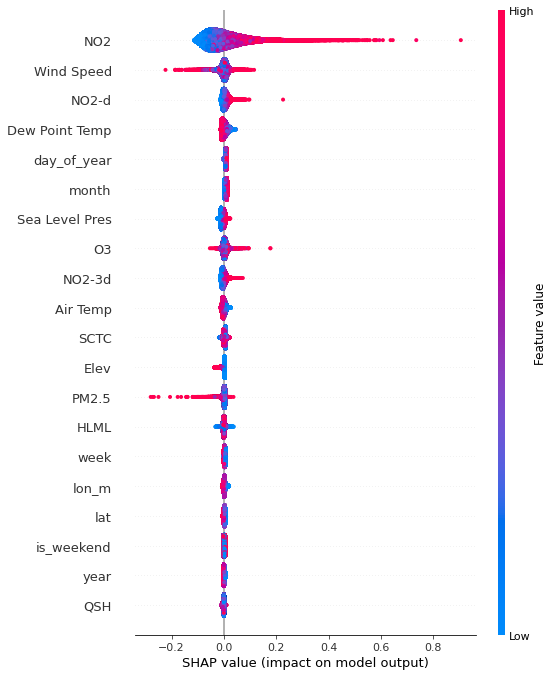

In [33]:
shap.summary_plot(np.mean(shap_values, axis=1), np.mean(X.numpy(), axis=1), feature_names=cols)

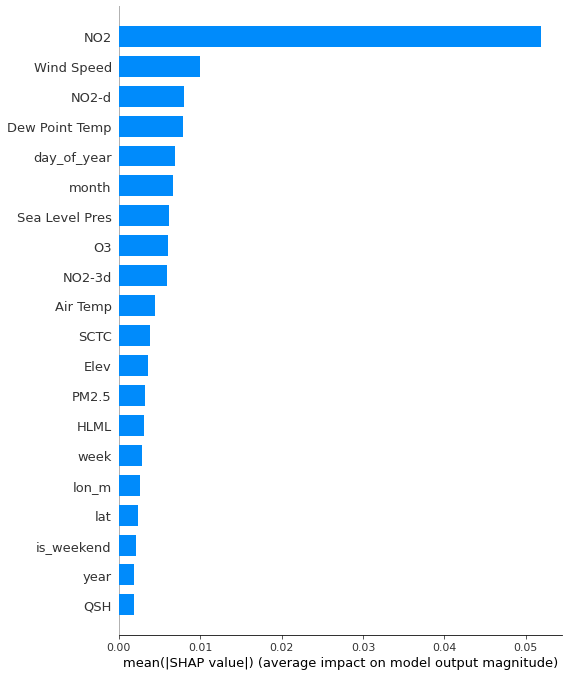

In [34]:
shap.summary_plot(np.mean(shap_values, axis=1), np.mean(X.numpy(), axis=1), feature_names=cols, plot_type='bar')

## Predictions

In [ ]:
print('Model performance in training datasets is:')
tr_preds, tr_metric = evaluation(tr_set, config)
print('Model performance in testing dataset is:')
dv_preds, dv_metric = evaluation(dv_set, config)

In [18]:
# 对整体数据集进行预测  predicting
real_train = ytrain * np.sqrt(std_no2) + std_mean
# pre_train = model.predict(xtrain)
pre_train = tr_preds
pre_train = pre_train * np.sqrt(std_no2) + std_mean

real_test = ytest * np.sqrt(std_no2) + std_mean
# pre_test = model.predict(xtest)
pre_test = dv_preds
pre_test = pre_test * np.sqrt(std_no2) + std_mean

In [ ]:
# 评价模型性能  Evaluation of model performance
# 训练集 Training dataset
mse = mean_squared_error(real_train, pre_train)
rmse = sqrt(mse)
mae = mean_absolute_error(real_train, pre_train)
r2 = r2_score(real_train, pre_train)
print('模型在训练集性能：','均方误差：%.6f' % mse, '均方根误差：%.6f' % rmse, '平均绝对误差：%.6f' % mae, 'R2：%.6f' % r2)
# 测试集  Testing dataset
val_mse = mean_squared_error(real_test, pre_test)
val_rmse = sqrt(val_mse)
val_mae = mean_absolute_error(real_test, pre_test)
val_r2 = r2_score(real_test, pre_test)
print('模型在测试集性能：','均方误差：%.6f' % val_mse, '均方根误差：%.6f' % val_rmse, '平均绝对误差：%.6f' % val_mae, 'R2：%.6f' % val_r2)

In [51]:
# 将预测数据和真实值匹配，并添加时间索引和站点名  megre predictions
test_res = pd.concat([pd.DataFrame(real_test,columns=[list_col[0]]),pd.DataFrame(pre_test,columns=[col_name])
                         ,pd.DataFrame(ytest_[:,1:],columns=['index','station'])],axis=1)
train_res = pd.concat([pd.DataFrame(real_train,columns=[list_col[0]]),pd.DataFrame(pre_train,columns=[col_name])
                          ,pd.DataFrame(ytrain_[:,1:],columns=['index','station'])],axis=1)
data_res = pd.concat([train_res,test_res],axis=0)
data_res['index'] = (pd.to_datetime(data_res['index']) + pd.Timedelta('-1 days')).astype(str)

In [53]:
# 读取预测数据，并加入其中 load predictions dataset
data_ = pd.read_csv(file_path + file_name_pre)

In [55]:
data_pre = pd.merge(data_, data_res.drop(columns=list_col[0]),how='left',on=['index','station'])

In [59]:
# 将预测值写入数据库  writing predictions dataset
data_pre.to_csv(file_path + file_name_pre,index=False)